<h1>Scout - Handover Report</h1>

Scout ltd are aiming to establish how Artificial Intelligence (AI) can be used to reduce the divide betweeen learners and employees in terms of employment qualifications with the view to building at tool that can be used by students , employers and educators.

The Greater Manchester AI Foundry has provided assistance to Scout and collaborated with them
to create a prototype tool in the form of a streamlit dashboard that implements AI techniques such as named entity recognition.

This notebook documents the collaboration and features the following sections:

<ol>
  <li>Project Scope</li>
  <li>Data Exploration</li>
  <li>Method Development(Named entity recognition)</li>
  <li>Prototype Build</li>
  <li>Future Works</li>
</ol>

<h1>1. Project Scope</h1>

The beneficiary is building a platform that will connect learners, educators, and employers using artificial intelligence. The aim is to produce a proof of concept for an employment/learning course pathway tool that can be used to identify important certifications/skills needed to find successful employment in user specified fields, in the form of an interactive dashboard.

At the scoping stage of the project, the potential application of AI techniques in natural language processing was discussed such as topic modelling. This was linked to conversations around the data that would be available for the assist. It was decided that data from an API would be used to demonstrate the proposed tools functionality.

Initial investigation suggested a solution could consist of using naiive bayes and topic modelling, however, further investigations and discussions with sector specialists led to the scope being altered such that a technique known as *Named entity recognition* became the focus of the assist. Ultimately, this technique was found to be applicable and useful, and an interactive dashboard was created to prove this concept. 

<h2>Deliverables</h2>
<ul>
    <li>Repository containing interactive notebooks that document the data exploration and early prototyping efforts.</li>
    <li>Repository containing an interactive dashboard, which demonstrates the application of ]named entity recognition for extracting key skills from job descriptions.</li>
    <li>Handover document describing the assistance and highlighting potential next steps (this document).</li>
</ul>
<h2>Wider impact</h2>
Throughout the collaboration, the value of the system to wider society, and the risk category of the system according to the European Commission AI
Regulation Proposal (21st April 2021) were considered.

<h3>Potential positive impacts</h3>
<ul>
<li>The Scout system has the potential to increase employment amongst wider society. The system has the potential to improve the recruitment
    process and itself may require new employees to develop and maintain.</li>
</ul>
<h3>Potential negative impacts</h3>
<ul>
    <li>If the Scout system is implemented poorly, wider society could lose opportunities, as the recruitment process could be hindered (rather than helped) by the system.</li>
</ul>
<h3>Risk category</h3>
The Proximity system was classified as limited risk in-line with the European Commision AI Regulation proposal. 

## 2. Data Exploration

This section of the report documents the exploratory data analysis that was done as a part of the assistance. This was done to improve our understanding of the data, assess the suitability of the data with respect to named entity recognitio. Narrative text is included to supplement code and visualtions where appropriate. 

### Set-up

Import packages for data exploration and set a common colour palette for data visualisations.

In [1]:
import requests
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import re
import string 
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import csv
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from bs4 import BeautifulSoup as bs
from csv import DictWriter




# Read Data

1. Request data from the `devitjobs.uk` API and make queryable using `BeautifulSoup`. For this notebook all job data is being pulled from the api and is used without filtering based on user input.

In [2]:


URL = "https://devitjobs.uk/job_feed.xml"
page = requests.get(URL)

soup = bs(page.text, "xml") 

2. Make a dataframe containing the relevant data (with `pandas`).

In [3]:
titles = soup.find_all('title')
salary = soup.find_all('salary')
desc = soup.find_all('description')
jobs = soup.find_all('job')

data = []
for i in range(0,len(jobs)):
   rows = [jobs[i].id,titles[i].get_text(),
           salary[i].get_text(),desc[i].get_text()]
   data.append(rows)

df = pd.DataFrame(data,columns = ['Id','Title',
                                  'Salary','Description'], dtype="string")

3. Clean data so only relevant information is displayed in the dataframe (clean_data_df)

In [4]:
#cleaning data
initial_df = df


pattern = r'\[[^()]*\]'

initial_df["MinSalary"] = np.nan
initial_df["MaxSalary"] = np.nan

for index, row in initial_df.iterrows():
    # get id text
    #print(row['Id'])
    id_soup = bs(row['Id'],features="lxml")
    id = id_soup.get_text()
    #id = bs(row['Id'],features="lxml").get_text()

    # remove salary from title
    title = re.sub(pattern, '', row['Title'])

    # get description text
    description = bs(row['Description'],features="lxml").get_text()

    # split salary
    salary_text = re.findall("[\$0-9,\. ]*-[\$0-9,\. ]*", row['Salary'])
    _range_list = re.split("-", salary_text[0])
    
    range_list = []

    for salary in _range_list:
        range_list.append(locale.atof(salary))

    # assign
    initial_df.loc[index, "Id"] = id

    initial_df.loc[index, "Title"] = title

    initial_df.loc[index, "Description"] = description
    initial_df.loc[index, "Salary"] = str((range_list[0] + range_list[1])/2)
    initial_df.loc[index, "MinSalary"] = range_list[0]
    initial_df.loc[index, "MaxSalary"] = range_list[1]

clean_data_df  = initial_df

clean_data_df['Salary'] = clean_data_df['Salary'].astype(float)
display(clean_data_df)

,Id,Title,Salary,Description,MinSalary,MaxSalary
0,6023e9a16d1a1b0017ac621a,"iOS Developer (Remote, UK Based)",50000.0,"Salary 45,000 - 55,000 GBP per year Requiremen...",45000.0,55000.0
1,6023ead06d1a1b0017ac621b,Junior QA Engineer,30000.0,"Salary 25,000 - 35,000 GBP per year Requiremen...",25000.0,35000.0
2,6023eba46d1a1b0017ac621c,Software Developer in Test (SDET),35000.0,"Salary 30,000 - 40,000 GBP per year Requiremen...",30000.0,40000.0
3,6023ebd56d1a1b0017ac621d,Senior Android Developer,65000.0,"Salary 60,000 - 70,000 GBP per year Requiremen...",60000.0,70000.0
4,6023ecec6d1a1b0017ac621e,"Senior Software Engineer, Investment Platform",72500.0,"Salary 65,000 - 80,000 GBP per year Requiremen...",65000.0,80000.0
...,...,...,...,...,...,...
449,6408bdeebb39e3d0af72596b,Lead Developer - GOV.UK,75000.0,"Salary 60,000 - 90,000 GBP per year Requiremen...",60000.0,90000.0
450,6408be0abb39e3d0af72596f,Lead Developer - GOV.UK Pay,75000.0,"Salary 60,000 - 90,000 GBP per year Requiremen...",60000.0,90000.0
451,6409bea296503e6f8a1d9694,DevOps / Site Reliability Engineer,205000.0,"Salary 190,000 - 220,000 GBP per year Requirem...",190000.0,220000.0
452,6409dc4e96503e6f8a1d96e2,Java Developer 2 years + - Enterprise Software,35000.0,"Salary 30,000 - 40,000 GBP per year Requiremen...",30000.0,40000.0


### Explore categorical variables

Explore the key categorical variables on the dataframe. Establish how many unique categories there are within each column

In [5]:
clean_data_df.nunique()

Id             454
Title          400
Salary          43
Description    454
MinSalary       23
MaxSalary       26
dtype: int64

# 3. Method Development(Named entity recognition)

### Set-up

Import packages for named entity recognition.

In [6]:
import pandas as pd
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from bs4 import BeautifulSoup as bs
import csv
import spacy
#python -m spacy download en_core_web_sm

## 3.1 Retrieve user skills function

This function retrieves technical skills from a csv file. These skills would be specified by the user and represents what skills they currently possess.The skills form the csv file are outputed as a list for later use.

In [7]:
def retrieve_skill_list():
    file = open("technical_skills.csv", "r", encoding="utf8")
    raw_technical_skills = list(csv.reader(file))
    joint_skills = list(map(''.join, raw_technical_skills))
    technical_skills = list(map(lambda x: x.lower(), joint_skills))
    file.close()
    return technical_skills

## 3.2 Extract skills function

All skills extraction functions follow the following in regards to function.

### Use Spacy load() to import a model

We use the spacy en_core_web_sm model. To download the model you will first need to run a Python command to fetch the latest model and then use the Spacy load() method to load it.

Example:

python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')


### Create EntityRuler pattern matching rules

Next rules are created using Spacy’s EntityRuler. This powers the custom named entity recognition system and will look for pattern matches in the job description, assign a label to them called SKILL, and extract the named entities.

To create the list of patterns is currently based on skills within the IT industry and soft skills within the general field of careers.

### Example:
tech_skills = [
    {'label': 'SKILL', 'pattern': [{"LOWER": "python"}], 'id': 'python'},
    {'label': 'SKILL', 'pattern': [{"LOWER": "dw"}], 'id': 'data wrangling'},
    ]


The list of patterns can easily extend it to cover other areas, such as qualfications or skills in other fields by inserting your own strings where applicable.


Next the patterns are passed to the add_pipe() method and use before='ner' to ensure that Spacy overwrites any default named entities with the new SKILL entities. The patterns are then added to the ruler using add_patterns().

### Example: 

ruler = nlp.add_pipe('entity_ruler', before='ner')
ruler.add_patterns(tech_skills)


### Extract the skills to a new column
To run the custom named entity recognition model on our entire Pandas dataframe we can use the Pandas apply() method and a lambda function. A for loop loops over the entities and returns those where the label_ is SKILL.

The ent.text value contains the matched words, i.e. Python or MySQL, but we actually want the ent.ent_id_ value, since this will ensure all the values are equal, and we don’t have to deal with “scikit-learn”, “scikit learn” and “sklearn” when analysing the results.


Finally, we use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list. We get back a single column in our dataframe containing the SKILL named entities extracted.

Example:


    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
    
#remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

#Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


#use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

#Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)


In [8]:
def extract_tech_skills(dataframe):
    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    tech_skills = [
        {'label': 'SKILL', 'pattern': [{"LOWER": "python"}], 'id': 'python'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "r"}], 'id': 'r'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sas"}], 'id': 'sas'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "java"}], 'id': 'java'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c++"}], 'id': 'c++'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c#"}], 'id': 'c#'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c"}], 'id': 'c'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "javascript"}], 'id': 'javascript'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "html"}], 'id': 'html'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "css"}], 'id': 'css'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "php"}], 'id': 'php'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ruby"}], 'id': 'ruby'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scala"}], 'id': 'scala'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "perl"}], 'id': 'perl'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "matlab"}], 'id': 'matlab'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "hadoop"}], 'id': 'hadoop'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "spark"}], 'id': 'spark'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "hive"}], 'id': 'hive'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pig"}], 'id': 'pig'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "shark"}], 'id': 'shark'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "oozie"}], 'id': 'oozie'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "zookeeper"}], 'id': 'zookeeper'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "flume"}], 'id': 'flume'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mahout"}], 'id': 'mahout'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sqoop"}], 'id': 'sqoop'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "storm"}], 'id': 'storm'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kafka"}], 'id': 'kafka'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "cassandra"}], 'id': 'cassandra'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mongodb"}], 'id': 'mongodb'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "redis"}], 'id': 'redis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "elasticsearch"}], 'id': 'elasticsearch'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "neo4j"}], 'id': 'neo4j'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sql"}], 'id': 'sql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nosql"}], 'id': 'nosql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "postgresql"}], 'id': 'postgresql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "oracle"}], 'id': 'oracle'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mysql"}], 'id': 'mysql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sqlite"}], 'id': 'sqlite'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mariadb"}], 'id': 'mariadb'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mssql"}], 'id': 'mssql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "db2"}], 'id': 'db2'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pandas"}], 'id': 'pandas'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "spacy"}], 'id': 'spacy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nltk"}], 'id': 'nltk'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "gensim"}], 'id': 'gensim'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "huggingface"}], 'id': 'huggingface'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "transformers"}], 'id': 'transformers'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scikit-learn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scikit"}, {"LOWER": "learn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sklearn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "tensor"}, {"LOWER": "flow"}], 'id': 'tensorflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "tensorflow"}], 'id': 'tensorflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "keras"}], 'id': 'keras'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pytorch"}], 'id': 'pytorch'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "numpy"}], 'id': 'numpy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scipy"}], 'id': 'scipy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "matplotlib"}], 'id': 'matplotlib'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "seaborn"}], 'id': 'seaborn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "plotly"}], 'id': 'plotly'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "bokeh"}], 'id': 'bokeh'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "d3"}], 'id': 'd3'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "airflow"}], 'id': 'airflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "docker"}], 'id': 'docker'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kubernetes"}], 'id': 'kubernetes'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "aws"}], 'id': 'aws'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "amazon"}, {"LOWER": "web"}, {"LOWER": "services"}], 'id': 'aws'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "gcp"}], 'id': 'gcp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "google"}, {"LOWER": "cloud"}, {"LOWER": "platform"}], 'id': 'gcp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "azure"}], 'id': 'azure'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "machine learning"}], 'id': 'machine learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ml"}], 'id': 'machine learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "deep"}, {"LOWER": "learning"}], 'id': 'deep learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dl"}], 'id': 'deep learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "natural"}, {"LOWER": "language"}, {"LOWER": "processing"}], 'id': 'nlp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nlp"}], 'id': 'nlp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "computer"}, {"LOWER": "vision"}], 'id': 'computer vision'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "cv"}], 'id': 'computer vision'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "science"}], 'id': 'data science'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ds"}], 'id': 'data science'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "analysis"}], 'id': 'data analysis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "da"}], 'id': 'data analysis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "visualisation"}], 'id': 'data visualisation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "visualization"}], 'id': 'data visualization'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dv"}], 'id': 'data visualisation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "mining"}], 'id': 'data mining'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dm"}], 'id': 'data mining'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "engineering"}], 'id': 'data engineering'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "de"}], 'id': 'data engineering'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "analytics"}], 'id': 'data analytics'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "da"}], 'id': 'data analytics'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "warehouse"}], 'id': 'data warehouse'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dw"}], 'id': 'data warehouse'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "pipelines"}], 'id': 'data pipelines'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dp"}], 'id': 'data pipelines'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "munging"}], 'id': 'data munging'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dm"}], 'id': 'data munging'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "preparation"}], 'id': 'data preparation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dp"}], 'id': 'data preparation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "wrangling"}], 'id': 'data wrangling'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dw"}], 'id': 'data wrangling'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "cleaning"}], 'id': 'data cleaning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kotlin"}], 'id': 'kotlin'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "excel"}], 'id': 'excel'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "open"},{"LOWER": "cv"}], 'id': 'open cv'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "go"}], 'id': 'go'},
    ]

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(tech_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
  
    return dataframe


In [9]:
def extract_soft_skills(dataframe):
    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    soft_skills = [
        {'label': 'SKILL', 'pattern': [{"LOWER": "communication"}], 'id': 'communication'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "teamwork"}], 'id': 'teamwork'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "adaptability"}], 'id': 'adaptability'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "creative"}], 'id': 'creative'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "leadership"}], 'id': 'leadership'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "resourcefulness"}], 'id': 'resourcefulness'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "persuasive"}], 'id': 'persuasive'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "problem"}, {"LOWER": "solving"}], 'id': 'problem-solving'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "time"}, {"LOWER": "management"}], 'id': 'time management'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "descision"}, {"LOWER": "making"}], 'id': 'descision making'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "critical"}, {"LOWER": "thinker"}], 'id': 'critical thinker'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ambitious"}], 'id': 'ambitious'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "confident"}], 'id': 'confident'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "analytical"}], 'id': 'analytical'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "motivated"}], 'id': 'motivated'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "public"}, {"LOWER": "speaking"}], 'id': 'public speaking'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "innovative"}], 'id': 'innovative'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "respectful"}], 'id': 'respectful'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "detail"}, {"LOWER": "orientated"}], 'id': 'detail orientated'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "interpersonal"}, {"LOWER": "skills"}], 'id': 'interpersonal_skills'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "worker"}], 'id': 'worker'},
    ]



    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(soft_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
   
    return dataframe

In [10]:
def extract_user_skills(dataframe):

    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    user_skills = []

    list_of_input_skills = retrieve_skill_list()
    count = 0

    while count < len(list_of_input_skills):
      user_skills.append({'label': 'SKILL', 'pattern': [{"LOWER": list_of_input_skills[count]}], 'id': list_of_input_skills[count]},)
      count = count +1 

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(user_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
    
    
    return dataframe

In [11]:
ner_title_df = extract_tech_skills(clean_data_df)
ner_tech_skill_df = ner_title_df[['Title','Skills']].copy()
ner_soft_skills_df = extract_soft_skills(clean_data_df)
ner_soft_skills_df.rename(columns={'Skills': 'SoftSkills'}, inplace=True)
ner_skill_ex_df = ner_soft_skills_df[["SoftSkills",'Salary']].copy()
df_top_combined = pd.concat([ner_tech_skill_df,ner_skill_ex_df], axis = 1)

C:\Users\55147603\AppData\Local\Temp\ipykernel_3268\1278327850.py:124: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')
C:\Users\55147603\AppData\Local\Temp\ipykernel_3268\722588413.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')


In [12]:
display(df_top_combined)  

,Title,Skills,SoftSkills,Salary
0,"iOS Developer (Remote, UK Based)",[],[problem-solving],50000.0
1,Junior QA Engineer,[sql],[],30000.0
2,Software Developer in Test (SDET),[sql],[],35000.0
3,Senior Android Developer,[kotlin],[],65000.0
4,"Senior Software Engineer, Investment Platform","[azure, sql, c]","[problem-solving, analytical]",72500.0
...,...,...,...,...
449,Lead Developer - GOV.UK,"[aws, kubernetes, ruby]","[leadership, public speaking]",75000.0
450,Lead Developer - GOV.UK Pay,"[aws, python, java, ruby]","[leadership, public speaking]",75000.0
451,DevOps / Site Reliability Engineer,"[aws, azure]",[],205000.0
452,Java Developer 2 years + - Enterprise Software,"[java, postgresql, sql, oracle]",[],35000.0


### Analyse the distribution of named entities

The dataset above contains a column called skills that includes a list of the unique named entities recognised by our custom named entity recognition system. To analyse these skills individually we can use the Pandas explode() function to split the list up over multiple rows. The data is split into rows and the skill and the salary is returned for each one.

To understand which skills for roles are most sought after by employers in our data we can use the Pandas groupby() function with an agg() function.The is grouped data by the individual skill and then the number of roles in which it appears is calculated as well as the minimum, maximum,and median salary for each skill.

In [13]:
df_skills = df_top_combined.explode('Skills')
df_summary = df_skills.groupby('Skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
df_sal_summary= df_skills.groupby('Skills').agg(roles=('Title', 'count'),min_salary=('Salary', 'min'),med_salary=('Salary','median'),max_salary=('Salary', 'max'),).sort_values('roles', ascending=False)


<AxesSubplot: xlabel='Skills'>

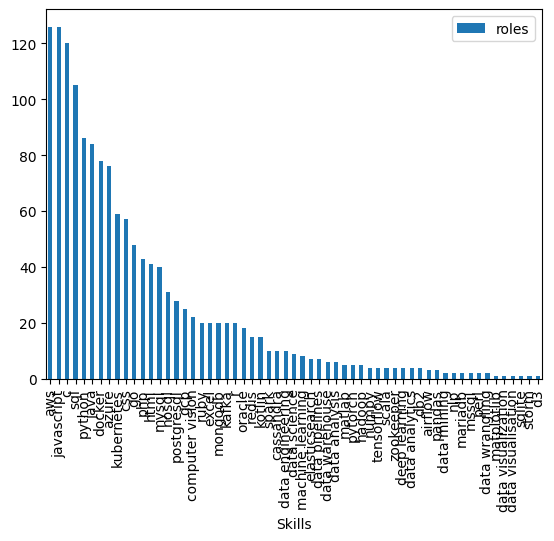

In [14]:
display(df_summary.plot(kind='bar'))

<AxesSubplot: xlabel='Skills'>

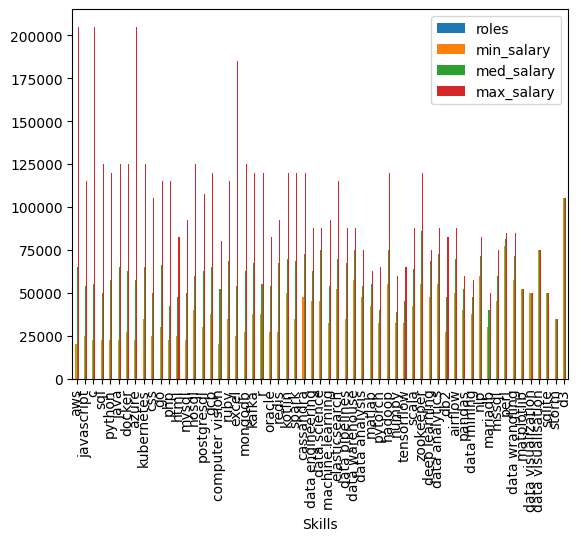

In [15]:
display(df_sal_summary.plot(kind='bar'))

<AxesSubplot: xlabel='SoftSkills'>

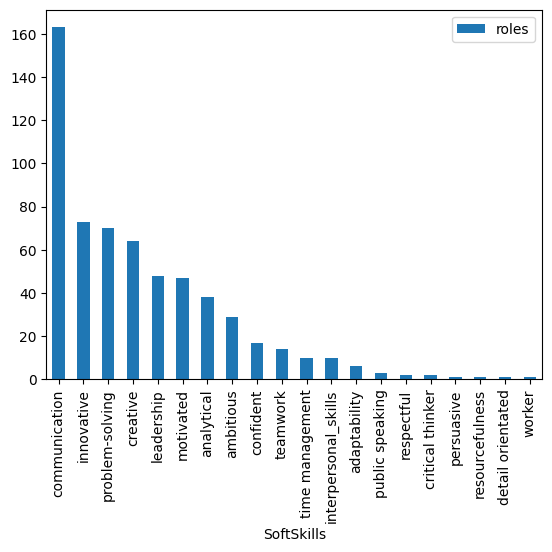

In [16]:
df_soft_skills = df_top_combined.explode('SoftSkills')
df_soft_summary = df_soft_skills.groupby('SoftSkills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
display(df_soft_summary.plot(kind='bar'))

In [17]:
#NER MISSING SKIILS 
ner_user_df = extract_user_skills(clean_data_df)

            #setting up general skills
ner_tech_skill_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
df_general_desc_skills = ner_tech_skill_df[['Title','technical_skills']].copy()
df_general_desc_skills.rename(columns={'technical_skills': 'general_skills'}, inplace=True)
   

            #setting up user skilss
ner_user_skills_df = ner_user_df[['Title','Skills']].copy()
ner_user_skills_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
df_users_skills = ner_user_skills_df['technical_skills']
            
df_combined = pd.concat([df_general_desc_skills,df_users_skills], axis = 1)

df_extract = df_combined[['general_skills','technical_skills']]
temp = df_extract[['general_skills','technical_skills']].applymap(set)
temp.rename(columns={'general_skills': 'missing_skills'}, inplace=True)
missing = temp.diff(periods=-1, axis=1).dropna(axis=1) 

df_missing_skill = pd.concat([df_combined ,missing], axis = 1)
df_missing_skill.rename(columns={'technical_skills': 'user_skills'}, inplace=True)

C:\Users\55147603\AppData\Local\Temp\ipykernel_3268\2901139756.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')


In [18]:
display(df_missing_skill)  

,Title,general_skills,user_skills,missing_skills
0,"iOS Developer (Remote, UK Based)",[],[],{}
1,Junior QA Engineer,[sql],[],{sql}
2,Software Developer in Test (SDET),[sql],[],{sql}
3,Senior Android Developer,[kotlin],[],{kotlin}
4,"Senior Software Engineer, Investment Platform","[azure, sql, c]",[],"{azure, sql, c}"
...,...,...,...,...
449,Lead Developer - GOV.UK,"[aws, kubernetes, ruby]",[],"{aws, kubernetes, ruby}"
450,Lead Developer - GOV.UK Pay,"[aws, python, java, ruby]","[aws, python, java]",{ruby}
451,DevOps / Site Reliability Engineer,"[aws, azure]",[aws],{azure}
452,Java Developer 2 years + - Enterprise Software,"[java, postgresql, sql, oracle]",[java],"{postgresql, sql, oracle}"


## Visualising missing skills

To understand which missing skills for roles are most sought after by employers in our data based on the users missing skills(technical_skills.csv representing user input) for each role we can use the Pandas groupby() function with an agg() function.

<AxesSubplot: xlabel='missing_skills'>

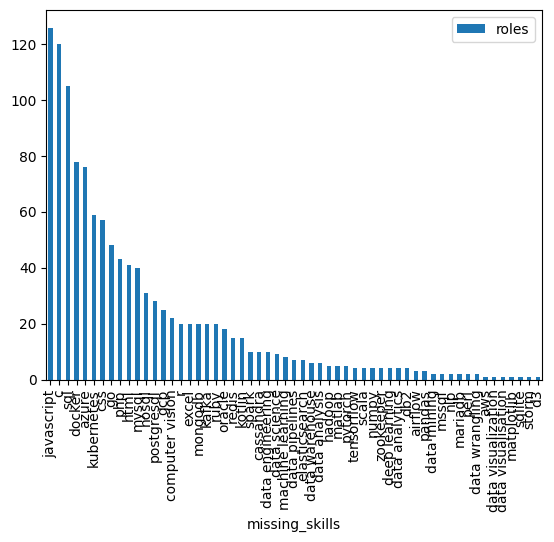

In [19]:
df_missing_skills = df_missing_skill.explode('missing_skills')
df_missing_summary = df_missing_skills.groupby('missing_skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)

display(df_missing_summary.plot(kind='bar'))



## 4. Prototype Build

After the model had been developed, it was refined and operationalised in the form of an interactive dashboard. This dashboard was created using a package called `streamlit`. The refined methods that underpin this interactive dashboard are shown with supporting descriptions in this section. In general, the methods are not robust and will return errors if they do not recieve data in the expected format.

<img src="job.PNG" width=900 height=500 />

<img src="dash.PNG" width=900 height=500 />

### Dashboard functionality:

### 4.1 - Module: named_entity_rec.py

The named_entity_rec model contains the code required to extract,tech,softskills and user skills from the dashboard interface. The functions in this module are used in 4.3. Below is a break of what each function in this module does.

<u>retrieve_skill_list()</u>

This function reads the csv file technical_skill.csv which contains user inputted skills and returns items in the files as a python list.

<u>extract_tech_skills(dataframe)</u>

This functions takes a dataframe and using named entity recognition returns a new dataframe containing technical skills found in each job description. For more information on how this works refer to **3.2 Extract skills function**.

<ul>
    <li>Use Spacy load() to import a model</li>
    <li>Create EntityRuler pattern matching rules</li>
    <li>Extract the skills to a new column</li>
</ul>

<u>extract_soft_skills(dataframe)</u>

This functions takes a dataframe and using named entity recognition returns a new dataframe containing soft skills found in each job description. For more information on how this works refer to **3.2 Extract skills function**.

<ul>
    <li>Use Spacy load() to import a model</li>
    <li>Create EntityRuler pattern matching rules</li>
    <li>Extract the skills to a new column</li>
</ul>

<u>extract_user_skills(dataframe)</u>


<ul>
    <li>Use Spacy load() to import a model</li>
    <li>Create EntityRuler pattern matching rules</li>
    <li>Extract the skills to a new column</li>
</ul>





In [20]:

import pandas as pd
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, 'en_CA.UTF-8')
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from bs4 import BeautifulSoup as bs
import csv
import spacy

def retrieve_skill_list():
    file = open("technical_skills.csv", "r", encoding="utf8")
    raw_technical_skills = list(csv.reader(file))
    joint_skills = list(map(''.join, raw_technical_skills))
    technical_skills = list(map(lambda x: x.lower(), joint_skills))
    file.close()
    return technical_skills
def extract_tech_skills(dataframe):
    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    tech_skills = [
        {'label': 'SKILL', 'pattern': [{"LOWER": "python"}], 'id': 'python'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "r"}], 'id': 'r'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sas"}], 'id': 'sas'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "java"}], 'id': 'java'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "excel"}], 'id': 'excel'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c++"}], 'id': 'c++'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c#"}], 'id': 'c#'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "c"}], 'id': 'c'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "javascript"}], 'id': 'javascript'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "html"}], 'id': 'html'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "css"}], 'id': 'css'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "php"}], 'id': 'php'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ruby"}], 'id': 'ruby'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scala"}], 'id': 'scala'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "perl"}], 'id': 'perl'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "matlab"}], 'id': 'matlab'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "hadoop"}], 'id': 'hadoop'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "spark"}], 'id': 'spark'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "hive"}], 'id': 'hive'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pig"}], 'id': 'pig'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "shark"}], 'id': 'shark'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "oozie"}], 'id': 'oozie'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "zookeeper"}], 'id': 'zookeeper'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "flume"}], 'id': 'flume'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mahout"}], 'id': 'mahout'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sqoop"}], 'id': 'sqoop'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "storm"}], 'id': 'storm'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kafka"}], 'id': 'kafka'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "cassandra"}], 'id': 'cassandra'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mongodb"}], 'id': 'mongodb'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "redis"}], 'id': 'redis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "elasticsearch"}], 'id': 'elasticsearch'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "neo4j"}], 'id': 'neo4j'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sql"}], 'id': 'sql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nosql"}], 'id': 'nosql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "postgresql"}], 'id': 'postgresql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "oracle"}], 'id': 'oracle'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mysql"}], 'id': 'mysql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sqlite"}], 'id': 'sqlite'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mariadb"}], 'id': 'mariadb'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "mssql"}], 'id': 'mssql'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "db2"}], 'id': 'db2'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pandas"}], 'id': 'pandas'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "spacy"}], 'id': 'spacy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nltk"}], 'id': 'nltk'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "gensim"}], 'id': 'gensim'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "huggingface"}], 'id': 'huggingface'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "transformers"}], 'id': 'transformers'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scikit-learn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scikit"}, {"LOWER": "learn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "sklearn"}], 'id': 'scikit-learn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "tensor"}, {"LOWER": "flow"}], 'id': 'tensorflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ux"}, {"LOWER": "design"}], 'id': 'ux design'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ui"}, {"LOWER": "design"}], 'id': 'ui design'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "tensorflow"}], 'id': 'tensorflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "keras"}], 'id': 'keras'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "pytorch"}], 'id': 'pytorch'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "numpy"}], 'id': 'numpy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "scipy"}], 'id': 'scipy'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "matplotlib"}], 'id': 'matplotlib'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "seaborn"}], 'id': 'seaborn'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "plotly"}], 'id': 'plotly'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "bokeh"}], 'id': 'bokeh'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "d3"}], 'id': 'd3'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "airflow"}], 'id': 'airflow'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "docker"}], 'id': 'docker'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kubernetes"}], 'id': 'kubernetes'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "aws"}], 'id': 'aws'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "amazon"}, {"LOWER": "web"}, {"LOWER": "services"}], 'id': 'aws'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "gcp"}], 'id': 'gcp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "google"}, {"LOWER": "cloud"}, {"LOWER": "platform"}], 'id': 'gcp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "azure"}], 'id': 'azure'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "machine learning"}], 'id': 'machine learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ml"}], 'id': 'machine learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "deep"}, {"LOWER": "learning"}], 'id': 'deep learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dl"}], 'id': 'deep learning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "natural"}, {"LOWER": "language"}, {"LOWER": "processing"}], 'id': 'nlp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "nlp"}], 'id': 'nlp'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "computer"}, {"LOWER": "vision"}], 'id': 'computer vision'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "cv"}], 'id': 'computer vision'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "science"}], 'id': 'data science'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ds"}], 'id': 'data science'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "analysis"}], 'id': 'data analysis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "da"}], 'id': 'data analysis'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "visualisation"}], 'id': 'data visualisation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "visualization"}], 'id': 'data visualization'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dv"}], 'id': 'data visualisation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "mining"}], 'id': 'data mining'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dm"}], 'id': 'data mining'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "engineering"}], 'id': 'data engineering'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "de"}], 'id': 'data engineering'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "analytics"}], 'id': 'data analytics'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "da"}], 'id': 'data analytics'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "warehouse"}], 'id': 'data warehouse'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dw"}], 'id': 'data warehouse'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "pipelines"}], 'id': 'data pipelines'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dp"}], 'id': 'data pipelines'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "munging"}], 'id': 'data munging'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dm"}], 'id': 'data munging'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "preparation"}], 'id': 'data preparation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dp"}], 'id': 'data preparation'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "wrangling"}], 'id': 'data wrangling'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "dw"}], 'id': 'data wrangling'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "data"}, {"LOWER": "cleaning"}], 'id': 'data cleaning'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "kotlin"}], 'id': 'kotlin'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "excel"}], 'id': 'excel'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "open"},{"LOWER": "cv"}], 'id': 'open cv'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "go"}], 'id': 'go'},
    ]

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(tech_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
    #title_skills_df =dataframe[['Title', 'Skills']].copy()
  #  st.dataframe(title_skills_df)


    #Analyse the distribution of named entities

   # df_skills = dataframe.explode('Skills')

   # df_summary = df_skills.groupby('Skills').agg(
   #     roles=('Title', 'count'),
        
  #  ).sort_values('roles', ascending=False)

   # st.dataframe(df_summary)
    
    return dataframe

def extract_soft_skills(dataframe):
    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    soft_skills = [
        {'label': 'SKILL', 'pattern': [{"LOWER": "communication"}], 'id': 'communication'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "teamwork"}], 'id': 'teamwork'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "adaptability"}], 'id': 'adaptability'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "creative"}], 'id': 'creative'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "leadership"}], 'id': 'leadership'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "resourcefulness"}], 'id': 'resourcefulness'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "persuasive"}], 'id': 'persuasive'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "problem"}, {"LOWER": "solving"}], 'id': 'problem-solving'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "time"}, {"LOWER": "management"}], 'id': 'time management'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "descision"}, {"LOWER": "making"}], 'id': 'descision making'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "critical"}, {"LOWER": "thinker"}], 'id': 'critical thinker'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "ambitious"}], 'id': 'ambitious'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "confident"}], 'id': 'confident'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "analytical"}], 'id': 'analytical'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "motivated"}], 'id': 'motivated'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "public"}, {"LOWER": "speaking"}], 'id': 'public speaking'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "innovative"}], 'id': 'innovative'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "respectful"}], 'id': 'respectful'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "detail"}, {"LOWER": "orientated"}], 'id': 'detail orientated'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "interpersonal"}, {"LOWER": "skills"}], 'id': 'interpersonal_skills'},
        {'label': 'SKILL', 'pattern': [{"LOWER": "worker"}], 'id': 'worker'},
    ]



    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(soft_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
    #title_skills_df =dataframe[['Title', 'Skills']].copy()
  #  st.dataframe(title_skills_df)


    #Analyse the distribution of named entities

   # df_skills = dataframe.explode('Skills')

   # df_summary = df_skills.groupby('Skills').agg(
   #     roles=('Title', 'count'),
        
  #  ).sort_values('roles', ascending=False)

   # st.dataframe(df_summary)
    
    return dataframe

def extract_user_skills(dataframe):

    #Use Spacy load() to import a model

    nlp = spacy.load('en_core_web_sm')


    # Create EntityRuler pattern matching rules
    user_skills = []

    list_of_input_skills = retrieve_skill_list()
    count = 0

    while count < len(list_of_input_skills):
      user_skills.append({'label': 'SKILL', 'pattern': [{"LOWER": list_of_input_skills[count]}], 'id': list_of_input_skills[count]},)
      count = count +1 

    ruler = nlp.add_pipe('entity_ruler', before='ner')
    ruler.add_patterns(user_skills)

    #Clean incoming data 

    # Cleaning of data Convert all text to lower cases Delete all tabulation,spaces, and new lines, Delete all numericals Delete nltk's defined stop words,Lemmatize text   
    dataframe ['Description'] = dataframe['Description'].apply(lambda x: " ".join(x.lower()for x in x.split()))
## remove tabulation and punctuation
    dataframe ['Description'] = dataframe ['Description'].str.replace('[^\w\s]',' ')

    #Extract the skills to a new column
    dataframe['Skills'] = dataframe['Description'].apply(lambda x: [ent.ent_id_ for ent in nlp(x).ents if ent.label_ == 'SKILL'])


    # use another lambda function to use set() to de-duplicate the values and return only the unique matches in a Python list
    dataframe['Skills'] = dataframe['Skills'].apply(lambda x: list(set(x)))

    #Use the named entities to clean the dataset

    dataframe[['Title', 'Skills']].sort_values('Skills', key=lambda x: x.str.len(), ascending=True).head(100)
    #title_skills_df =dataframe[['Title', 'Skills']].copy()
  #  st.dataframe(title_skills_df)


    #Analyse the distribution of named entities

   # df_skills = dataframe.explode('Skills')

   # df_summary = df_skills.groupby('Skills').agg(
   #     roles=('Title', 'count'),
        
  #  ).sort_values('roles', ascending=False)

   # st.dataframe(df_summary)
    
    return dataframe


### 4.2 - File: technical_skill.csv

The technical_skill.csv file consists of skills inputted by the user in the dashboard interface. These skills are used to determine what skills the user is missing in job descriptions in the module code below.

### 4.3 - Module: named_entity_search.py

This section of code is for the streamlit dashboard interface, all user interactions with the system is handled through this.

**Set up**

Install the requirements through requirements.txt. This spacy model may need to be installed seperately > python -m spacy download en_core_web_sm m.
Import all the required modules.

In [21]:
import requests
import pandas as pd
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import re
import string 
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import csv
from nltk import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
from bs4 import BeautifulSoup as bs
from csv import DictWriter
import named_entity_rec

Retrieves data in xml format from devit jobs board using beautiful soup.

In [22]:
URL = "https://devitjobs.uk/job_feed.xml"
page = requests.get(URL)

soup = bs(page.text, "xml") 

Jobs, job title, description and salary are found using beautiful soup are arranged into a dataframe this step is not needed if different data is being used as long as the columns names in the end data frame remains the same.

In [23]:
titles = soup.find_all('title')
salary = soup.find_all('salary')
desc = soup.find_all('description')
jobs = soup.find_all('job')

data = []
for i in range(0,len(jobs)):
   rows = [jobs[i].id,titles[i].get_text(),
           salary[i].get_text(),desc[i].get_text()]
   data.append(rows)

df = pd.DataFrame(data,columns = ['Id','Title',
                                  'Salary','Description'], dtype="string")

#cleaning data
initial_df = df

In [24]:
pattern = r'\[[^()]*\]'

initial_df["MinSalary"] = np.nan
initial_df["MaxSalary"] = np.nan

for index, row in initial_df.iterrows():
    # get id text
    #print(row['Id'])
    id_soup = bs(row['Id'],features="lxml")
    id = id_soup.get_text()
    #id = bs(row['Id'],features="lxml").get_text()

    # remove salary from title
    title = re.sub(pattern, '', row['Title'])

    # get description text
    description = bs(row['Description'],features="lxml").get_text()

    # split salary
    salary_text = re.findall("[\$0-9,\. ]*-[\$0-9,\. ]*", row['Salary'])
    _range_list = re.split("-", salary_text[0])
    
    range_list = []

    for salary in _range_list:
        range_list.append(locale.atof(salary))

    # assign
    initial_df.loc[index, "Id"] = id

    initial_df.loc[index, "Title"] = title

    initial_df.loc[index, "Description"] = description
    initial_df.loc[index, "Salary"] = str((range_list[0] + range_list[1])/2)
    initial_df.loc[index, "MinSalary"] = range_list[0]
    initial_df.loc[index, "MaxSalary"] = range_list[1]
    

clean_data_df  = initial_df
clean_data_df['Salary'] = clean_data_df['Salary'].astype(float)

Setting the side bar for the streamlit dashboard, giving the users options to search via Title or description and input their own skills.

In [25]:
menu =["Title Search","Description Search"]
with st.sidebar:
      
    st.subheader("Main Menu")
    choice = st.selectbox("Menu List",menu)

    st.subheader("User skills")
    search_term = st.text_input("Enter skill")
    button_clicked = st.button("OK")

2023-03-10 09:32:27.893 
  command:

    streamlit run C:\Users\55147603\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py [ARGUMENTS]


If button_clicked is pressed the string in search term is stored in a dictionary and added to technical_skill.csv in the Technical skills column this csv file is then used to display the skills in the side bar. 

In [26]:
if button_clicked:
    dict = {'Technical_Skills': search_term}

    field_names = ['Technical_Skills']
    with open('technical_skills.csv', 'a',newline='') as f_object:
        dictwriter_object = DictWriter(f_object, fieldnames=field_names)
        dictwriter_object.writerow(dict)
        f_object.close()

    #with st.expander("See explanation"):
    df = pd.read_csv('technical_skills.csv')

    # Sidebar - Sector selection
    sorted_sector_unique = sorted( df['Technical_Skills'].unique() )
    selected_sector = st.sidebar.multiselect('Technical_Skills', sorted_sector_unique, sorted_sector_unique)

    # Filtering data
    df_selected_sector = df[ (df['Technical_Skills'].isin(selected_sector)) ]
    df_selected_sector.to_csv('technical_skills.csv',index=False)

In [27]:
st.title("Scout Job Search")

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

### 4.3.1 Title Search 

The dashboard provides the functionality for users to search through a dataframe via title or description, in this case title. a two collumed form is used for user input.

In [28]:
if choice == "Title Search":
    st.subheader("Title Search")

    with st.form(key='searchform'):
        nav1,nav2= st.columns([2,1])

        with nav1:
            search_term = st.text_input("Search by Title")
        with nav2:
            st.text("Search")
            submit_search = st.form_submit_button(label="Search")

### 4.3.2 Title dataframe

Based on the user search input a new dataframe is created consisting of jobs where the user inputed string is contained within the title column of the dataframe.

In [29]:
if submit_search:
    st.success ("You searched for {} jobs".format(search_term))
    title_search_df = clean_data_df[clean_data_df.Title.str.contains(pat=search_term,case=False)]
    num_results = len(title_search_df.index)
    
    st.subheader("Showing {} jobs with {} in the title".format(num_results,search_term))
    simplified_title_search = title_search_df.iloc[:, [1,2,3,4,5]].copy()
    st.dataframe(simplified_title_search)

### 4.3.3 - General top skill extraction 

Technical and soft skills are extracted from the title search dataframe and placed in a new dataframe using both the **extract_tech_skills()** and **extract_soft_skills()** function from the **named_entity_rec()** module. The extracted title, tech_skills,softskills and salarys for each job are concatenated into a new dataframe **df_top_combined**.

<b>**title_search_df** is defined by the user on the stremalit dashboard and will therefore not run in this notebook</b>

In [30]:
st.subheader("NER Skill Extraction Tool")
ner_title_df = named_entity_rec.extract_tech_skills(title_search_df)
ner_tech_skill_df = ner_title_df[['Title','Skills']].copy()
ner_soft_skills_df = named_entity_rec.extract_soft_skills(title_search_df)
ner_soft_skills_df.rename(columns={'Skills': 'SoftSkills'}, inplace=True)
ner_skill_ex_df = ner_soft_skills_df[["SoftSkills",'Salary']].copy()
            
df_top_combined = pd.concat([ner_tech_skill_df,ner_skill_ex_df], axis = 1)
st.dataframe(df_top_combined)

NameError: name 'title_search_df' is not defined

### 4.3.4 Most important Skills 


**df_top_combined** contains a column called skills that includes a list of the unique named entities recognised by our custom named entity recognition system. To analyse these skills individually we can use the Pandas explode() function to split the list up over multiple rows. To understand which skills for roles are most sought after by employers in our data we can use the Pandas groupby() function with an agg() function.The is grouped data by the individual skill and then the number of roles in which it appears is calculated as well as the minimum, maximum,and median salary for each skill. The skills to roles chart and salary potential chart are placed within two seperate columns on the page.

In [ ]:
st.header("The most important technical skills for {} jobs ".format(search_term))
df_skills = df_top_combined.explode('Skills')
df_summary = df_skills.groupby('Skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
df_sal_summary= df_skills.groupby('Skills').agg(roles=('Title', 'count'),min_salary=('Salary', 'min'),med_salary=('Salary','median'),max_salary=('Salary', 'max'),).sort_values('roles', ascending=False)
            
    
col1, col2 = st.columns(2)

with col1:
    st.subheader("Skill to roles")
    st.bar_chart(df_summary)

with col2:
    st.subheader("Skill to salary potential for {} jobs".format(search_term))
    st.bar_chart(df_sal_summary)

with st.expander("For information on the above data"):
    st.dataframe(df_sal_summary)

### 4.3.5 Missing skills identification

In order to search for missing skills the chosen dataframe is used either title_search_df or description_search_df and the **extract_user_skills()** is used to extract named entites from each job description.

In [ ]:
st.subheader("NER Missing Skill Extraction Tool")
st.subheader("Missing Skills for {} jobs".format(search_term))
ner_user_df = named_entity_rec.extract_user_skills(title_search_df)

#### setting up general skills

Setting up general skiils dataframe with appropriate columns for comparisons in **setting missing skills** section

In [ ]:
ner_tech_skill_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
df_general_desc_skills = ner_tech_skill_df[['Title','technical_skills']].copy()
df_general_desc_skills.rename(columns={'technical_skills': 'general_skills'}, inplace=True)

#### setting user skills

Setting up user skiils dataframe with appropriate columns for comparisons in **setting missing skills** section

In [ ]:
ner_user_skills_df = ner_user_df[['Title','Skills']].copy()
ner_user_skills_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
df_users_skills = ner_user_skills_df['technical_skills']

#### setting missing skills

Using the **df_general_desc_skills** and **df_users_skills** the users missing skills for each job has been added to a new dataframe **df_missing_skill**

In [ ]:
df_combined = pd.concat([df_general_desc_skills,df_users_skills], axis = 1)

df_extract = df_combined[['general_skills','technical_skills']]
temp = df_extract[['general_skills','technical_skills']].applymap(set)
temp.rename(columns={'general_skills': 'missing_skills'}, inplace=True)
missing = temp.diff(periods=-1, axis=1).dropna(axis=1) 

df_missing_skill = pd.concat([df_combined ,missing], axis = 1)
df_missing_skill.rename(columns={'technical_skills': 'user_skills'}, inplace=True)
            
st.dataframe(df_missing_skill)

#### Most important missing skills

**df_missing_skill** contains a column called missing_skills that includes a list of the unique named entities recognised by our custom named entity recognition system. To analyse these skills individually we can use the Pandas explode() function to split the list up over multiple rows. this allows us to view/deteremine the most important skills the user is missing using the Pandas groupby() function with an agg() function and displaying the data in a new dataframe.

In [ ]:
st.subheader("The most important missing skills for {} jobs".format(search_term))
df_missing_skills = df_missing_skill.explode('missing_skills')
df_missing_summary = df_missing_skills.groupby('missing_skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
st.bar_chart(df_missing_summary)
with st.expander("See explanation"):
    st.dataframe(df_missing_summary)

### Description Search 

The code for the search via description is the same as searching via title. However, instead of searching for the userinput string in the title column the the string is searched for in the description column of the dataframe.

elif choice == "Description Search":
    st.subheader("Description Search")

    with st.form(key='searchform'):
        nav1,nav2,= st.columns([2,1])

        with nav1:
            search_term = st.text_input("Search by Description")
            
        with nav2:
            st.text("Search")
            submit_search = st.form_submit_button(label="Search")

    if submit_search:
        st.success ("You searched for {} jobs".format(search_term))
        description_search_df = clean_data_df[clean_data_df.Description.str.contains(pat=search_term,case=False)]
        num_results = len(description_search_df.index)
        st.subheader("Showing {} jobs with {} in the description".format(num_results,search_term))
        simplified_desc_search = description_search_df.iloc[:, [1,2,3,4,5]].copy()
        st.dataframe(simplified_desc_search)
            
        st.subheader("NER Skill Extraction Tool")
        ner_title_df = named_entity_rec.extract_tech_skills(description_search_df)
        ner_tech_skill_df = ner_title_df[['Title','Skills']].copy()
        ner_soft_skills_df = named_entity_rec.extract_soft_skills(description_search_df)
        ner_soft_skills_df.rename(columns={'Skills': 'SoftSkills'}, inplace=True)
        ner_skill_ex_df = ner_soft_skills_df[["SoftSkills","Salary"]].copy()
            
        df_top_combined = pd.concat([ner_tech_skill_df,ner_skill_ex_df], axis = 1)
        st.dataframe(df_top_combined)
        st.header("The most important technical skills for {} jobs ".format(search_term))
        df_skills = df_top_combined.explode('Skills')
        df_summary = df_skills.groupby('Skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
        df_sal_summary= df_skills.groupby('Skills').agg(roles=('Title', 'count'),min_salary=('Salary', 'min'),med_salary=('Salary','median'),max_salary=('Salary', 'max'),).sort_values('roles', ascending=False)
            
        col1, col2 = st.columns(2)

        with col1:
            st.subheader("Skill to roles")
            st.bar_chart(df_summary)

        with col2:
            st.subheader("Skill to salary potential for {} jobs".format(search_term))
            st.bar_chart(df_sal_summary)

        with st.expander("For information on the above data"):
            st.dataframe(df_sal_summary)

           

        st.subheader("The most important soft skills for {} jobs".format(search_term))
        df_soft_skills = df_top_combined.explode('SoftSkills')
        df_soft_summary = df_soft_skills.groupby('SoftSkills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
        st.bar_chart(df_soft_summary)
        with st.expander("See explanation"):
            st.dataframe(df_soft_summary)
            

        st.subheader("NER Missing Skill Extraction Tool")
        st.subheader("Missing Skills for {} jobs".format(search_term))
        ner_user_df = named_entity_rec.extract_user_skills(description_search_df)
            
        #setting up general skills
        ner_tech_skill_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
        df_general_desc_skills = ner_tech_skill_df[['Title','technical_skills']].copy()
        df_general_desc_skills.rename(columns={'technical_skills': 'general_skills'}, inplace=True)



        #setting up user skilss
        ner_user_skills_df = ner_user_df[['Title','Skills']].copy()
        ner_user_skills_df.rename(columns={'Skills': 'technical_skills'}, inplace=True)
        df_users_skills = ner_user_skills_df['technical_skills']
            
        df_combined = pd.concat([df_general_desc_skills,df_users_skills], axis = 1)

        df_extract = df_combined[['general_skills','technical_skills']]
        temp = df_extract[['general_skills','technical_skills']].applymap(set)
        temp.rename(columns={'general_skills': 'missing_skills'}, inplace=True)
        missing = temp.diff(periods=-1, axis=1).dropna(axis=1) 

        df_missing_skill = pd.concat([df_combined ,missing], axis = 1)
        df_missing_skill.rename(columns={'technical_skills': 'user_skills'}, inplace=True)
            
        st.dataframe(df_missing_skill)

        st.subheader("The most important missing skills for {} jobs".format(search_term))
        df_missing_skills = df_missing_skill.explode('missing_skills')
        df_missing_summary = df_missing_skills.groupby('missing_skills').agg(roles=('Title', 'count'),).sort_values('roles', ascending=False)
        st.bar_chart(df_missing_summary)
        with st.expander("See explanation"):
            st.dataframe(df_missing_summary)
            

## 5. Future Development

This document describes assistance that has resulted in a successful proof-of-concept prototype. Further work is needed to turn it into a product that is ready to put to market. The following list highlights potential next steps:

Recommendations for next stage of development:

- Incoporating user qualifications as a pattern list for the named enity recognition system
- Extending the technical skills list pattern to include key skills from other career fields.
- Additional filters for job search(eg locations, qualifictaions)
- Exposing the model to a larger job database API. Such as indeed, glassdoor etc. The model could also use a database created by scout if they choose, so long as all column names remain the same as in the example.


Scout aims for next iteration of prototype

Improvement of job data 
- At the moment we are consuming Employer data from one API this could be expanded to include data from multiple APIs as to cover a wider range of job sectors.

Introduction of education data 
- Move to Education information data from multiple APIs for example sources such as https://www.hesa.ac.uk/support/tools-and-downloads/unistats which provides comparable sets of information about full- and part-time undergraduate courses. It is run by the Office for Students and is designed to meet the information needs of prospective students. Potentially search for data consisting of valid microcredential course to improve skills.

Integrate ChatGPT
– Functionality to be confirmed, but will likely incorporate:
	– Dashboard integration to enhance the user interface
	– Training the AI on Scout datasets (Jobs, Education, Platform Usage, etc)
